# Chapter 2: 평균 회귀 기초 (The Basics of Mean Reversion)
# 분석 리포트

> **생성 시간**: 2026-02-01 16:58:43
> **데이터 출처**: Ernest Chan's "Algorithmic Trading" (2013)

---

## 목차

1. [개요 및 문제 정의](#1-개요-및-문제-정의)
2. [사용 데이터](#2-사용-데이터)
3. [정상성 검정](#3-정상성-검정-stationarity-tests)
4. [공적분 검정](#4-공적분-검정-cointegration-tests)
5. [반감기 분석](#5-반감기-분석-half-life)
6. [전략 백테스트](#6-전략-백테스트)
7. [결론 및 권고사항](#7-결론-및-권고사항)

---

In [27]:
# 기본 설정 및 라이브러리 임포트
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as ts
import statsmodels.tsa.vector_ar.vecm as vm

# 경고 메시지 억제
warnings.filterwarnings('ignore')

# 차트 스타일 설정
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

In [28]:
# 허스트 지수 계산 함수 (genhurst.py)
def genhurst(z):
    """
    calculation of Hurst exponent given log price series z
    """
    z = pd.DataFrame(z)
    
    taus = np.arange(np.round(len(z)/10)).astype(int)
    logVar = np.empty(len(taus))

    for tau in taus:
        var_val = z.diff(tau).var(ddof=0)
        if hasattr(var_val, 'iloc'):
            var_val = var_val.iloc[0]
        logVar[tau] = np.log(var_val)
        
    X = np.log(taus)    
    Y = logVar[:len(taus)]
    X = X[np.isfinite(logVar)]
    Y = Y[np.isfinite(logVar)]

    X = sm.add_constant(X)
    model = sm.OLS(Y, X)
    results = model.fit()
    H = results.params[1]/2
    pVal = results.pvalues[1]
    return H, pVal

## 1. 개요 및 문제 정의

### 💡 해결하려는 문제

**"가격이 평균으로 되돌아오는 성질을 이용해 수익을 낼 수 있을까?"**

대부분의 금융 가격 시계열은 **기하 랜덤 워크(Geometric Random Walk)** 를 따르기 때문에 가격의 평균 회귀를 직접 거래할 수 없습니다. 그러나:

1. **정상성(Stationarity)을 가진 소수의 시계열**은 평균 회귀 거래가 가능
2. **공적분(Cointegration) 관계**를 이용하면 비정상 시계열들을 결합하여 정상 포트폴리오 생성 가능

### 📐 핵심 수학적 개념

| 개념 | 수식 | 의미 |
|------|------|------|
| **평균 회귀** | $\Delta y(t) = \lambda y(t-1) + \mu + \epsilon$ | 가격 변화가 현재 가격 수준에 의존 (λ < 0) |
| **허스트 지수** | $Var(\tau) \sim \tau^{2H}$ | H < 0.5: 평균회귀, H = 0.5: 랜덤워크, H > 0.5: 추세 |
| **반감기** | $t_{1/2} = -\log(2)/\lambda$ | 가격이 평균까지 절반 거리를 회복하는 시간 |
| **공적분** | $y_1 - \beta y_2 = \epsilon$ (정상) | 두 비정상 시계열의 선형 결합이 정상 |

---

## 2. 사용 데이터

### 📊 데이터셋 설명

| 파일명 | 내용 | 기간 | 용도 |
|--------|------|------|------|
| `inputData_USDCAD.csv` | USD/CAD 환율 (1분봉) | ~1216일 | 단일 시계열 정상성 검정 |
| `inputData_EWA_EWC.csv` | 호주(EWA)/캐나다(EWC) ETF | ~1500일 | 페어 공적분 검정 |
| `inputData_EWA_EWC_IGE.csv` | EWA/EWC + 천연자원(IGE) ETF | ~1500일 | 다중 자산 공적분 |

### 🎯 데이터 선정 이유

- **USD/CAD**: 캐나다 달러는 "원자재 통화"로 미국 달러와 다른 특성을 가짐
- **EWA-EWC**: 호주와 캐나다 경제 모두 **원자재 기반**이므로 공적분 가능성 높음
- **IGE**: 천연자원 ETF로 EWA/EWC와 경제적 연관성 존재

---

In [29]:
# 데이터 로드

# 1. USDCAD 데이터
usdcad_path = "inputData_USDCAD.csv"
if os.path.exists(usdcad_path):
    df_usdcad = pd.read_csv(usdcad_path)
    # 17:00 (1659분) 데이터만 추출
    usdcad = df_usdcad.loc[df_usdcad['Time'] == 1659, 'Close'].reset_index(drop=True)
    print(f"✓ USDCAD: {len(usdcad)} 데이터 포인트")
else:
    print("✗ USDCAD 데이터 없음")
    usdcad = None

# 2. EWA/EWC/IGE 데이터
ewa_ewc_ige_path = "inputData_EWA_EWC_IGE.csv"
if os.path.exists(ewa_ewc_ige_path):
    df_ewa_ewc_ige = pd.read_csv(ewa_ewc_ige_path)
    df_ewa_ewc_ige['Date'] = pd.to_datetime(df_ewa_ewc_ige['Date'], format='%Y%m%d')
    df_ewa_ewc_ige.set_index('Date', inplace=True)
    print(f"✓ EWA/EWC/IGE: {len(df_ewa_ewc_ige)} 데이터 포인트")
else:
    print("✗ EWA/EWC/IGE 데이터 없음")
    df_ewa_ewc_ige = None

✓ USDCAD: 1216 데이터 포인트
✓ EWA/EWC/IGE: 1500 데이터 포인트


## 3. 정상성 검정 (Stationarity Tests)

### 🔬 검정 목적

가격 시계열이 **평균 회귀**하는지 확인합니다. 평균 회귀하는 시계열에서는:
- 가격이 평균보다 높으면 → 다음 움직임은 **하락** 예상
- 가격이 평균보다 낮으면 → 다음 움직임은 **상승** 예상

### 3.1 ADF 검정 (Augmented Dickey-Fuller Test)

**검정 원리**: 다음 모델에서 $\lambda = 0$인지 검정

$$\Delta y(t) = \lambda y(t-1) + \mu + \alpha_1 \Delta y(t-1) + \epsilon_t$$

- **귀무가설 (H₀)**: $\lambda = 0$ (랜덤 워크, 평균 회귀 아님)
- **대립가설 (H₁)**: $\lambda < 0$ (평균 회귀)

In [30]:
if usdcad is not None:
    y = usdcad.values
    
    print("### 1.1 ADF 검정 (Augmented Dickey-Fuller Test)")
    adf_result = ts.adfuller(y, maxlag=1, regression='c', autolag=None)
    
    print(f"  ADF t-통계량:    {adf_result[0]:.4f}")
    print(f"  p-value:         {adf_result[1]:.4f}")
    print(f"  임계값 (1%):     {adf_result[4]['1%']:.4f}")
    print(f"  임계값 (5%):     {adf_result[4]['5%']:.4f}")
    
    if adf_result[0] < adf_result[4]['5%']:
        print("  → ✅ 귀무가설 기각: 정상 시계열 (5% 유의수준)")
    else:
        print("  → ❌ 귀무가설 채택 불가: 랜덤워크 가능성")

### 1.1 ADF 검정 (Augmented Dickey-Fuller Test)
  ADF t-통계량:    -1.8430
  p-value:         0.3593
  임계값 (1%):     -3.4357
  임계값 (5%):     -2.8639
  → ❌ 귀무가설 채택 불가: 랜덤워크 가능성


**USD/CAD 검정 결과:**

| 통계량 | 값 | 설명 |
|--------|------|------|
| t-통계량 | -1.8430 | 검정통계량 (더 음수일수록 좋음) |
| p-value | 0.3593 | 귀무가설이 참일 확률 |
| 임계값 (1%) | -3.4357 | 99% 신뢰수준 임계값 |
| 임계값 (5%) | -2.8639 | 95% 신뢰수준 임계값 |
| 임계값 (10%) | -2.5680 | 90% 신뢰수준 임계값 |

> ❌ **결론**: t-통계량이 임계값보다 덜 음수이므로 **귀무가설 기각 불가** → 랜덤 워크 가능성

> 💡 USD/CAD가 정상성 검정을 통과하지 못한 이유: 캐나다 달러는 **원자재 통화**이고 미국 달러는 그렇지 않아 장기적으로 다른 추세를 보일 수 있음

### 3.2 허스트 지수 (Hurst Exponent)

**검정 원리**: 시계열의 **확산 속도**를 측정

$$\langle |z(t+\tau) - z(t)|^2 \rangle \sim \tau^{2H}$$

| H 값 범위 | 시계열 특성 | 트레이딩 전략 |
|-----------|-------------|---------------|
| H < 0.5 | 평균 회귀 (Mean Reverting) | 평균회귀 매매 |
| H = 0.5 | 랜덤 워크 (Random Walk) | 예측 불가 |
| H > 0.5 | 추세 추종 (Trending) | 모멘텀 매매 |

In [31]:
if usdcad is not None:
    print("### 1.2 허스트 지수 (Hurst Exponent)")
    H, pVal = genhurst(np.log(y))
    
    print(f"  H = {H:.4f}")
    print(f"  p-value = {pVal:.6f}")
    
    if H < 0.5:
        print(f"  → ✅ H < 0.5: 평균 회귀 성향 (Mean Reverting)")
    elif H > 0.5:
        print(f"  → ⚠️ H > 0.5: 추세 추종 성향 (Trending)")
    else:
        print(f"  → ⚪ H ≈ 0.5: 랜덤 워크 (Random Walk)")

### 1.2 허스트 지수 (Hurst Exponent)
  H = 0.4758
  p-value = 0.000000
  → ✅ H < 0.5: 평균 회귀 성향 (Mean Reverting)


**USD/CAD 허스트 지수 결과:**

| 지표 | 값 |
|------|------|
| H | **0.4758** |
| p-value | 0.000000 |

> ✅ **해석**: H = 0.4758 < 0.5 → **약한 평균 회귀 성향** 존재

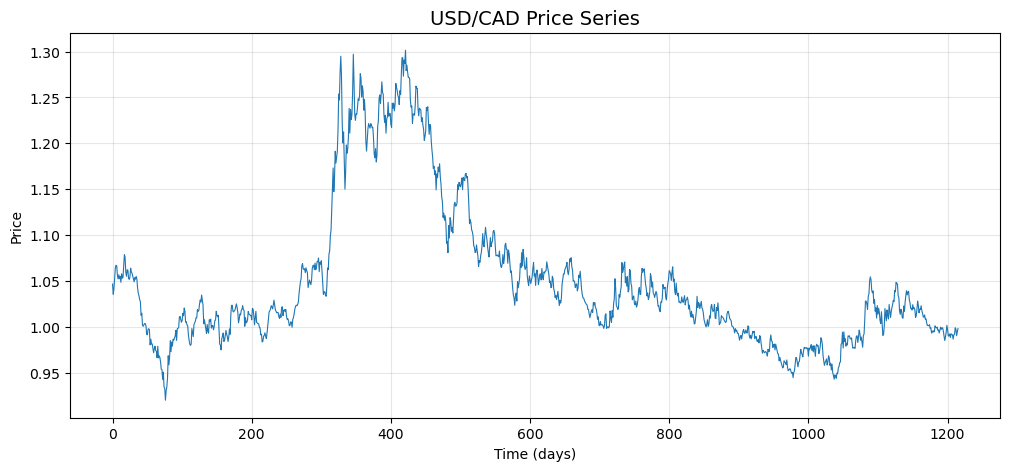

In [32]:
if usdcad is not None:
    plt.figure(figsize=(12, 5))
    plt.plot(y, linewidth=0.8)
    plt.title('USD/CAD Price Series', fontsize=14)
    plt.xlabel('Time (days)')
    plt.ylabel('Price')
    plt.grid(True, alpha=0.3)
    plt.show()

### 3.3 USD/CAD 가격 차트

> 📈 위 차트에서 USD/CAD 환율이 일정 범위 내에서 움직이는 것처럼 보이지만, ADF 검정에서 통계적으로 유의한 정상성을 확인하지 못함

---

## 4. 공적분 검정 (Cointegration Tests)

### 🎯 검정 목적

개별적으로는 비정상인 시계열들을 **선형 결합**하여 **정상인 포트폴리오**를 만들 수 있는지 확인합니다.

**핵심 아이디어**: $y_{EWC} - \beta \cdot y_{EWA}$가 정상이면 EWA와 EWC는 **공적분** 관계

### 4.1 EWA-EWC 페어 분석 (CADF Test)

**왜 EWA와 EWC인가?**
- **EWA**: iShares MSCI Australia ETF (호주 주식시장)
- **EWC**: iShares MSCI Canada ETF (캐나다 주식시장)
- 두 경제 모두 **원자재 수출 기반**이므로 유사한 경제 사이클을 가짐

**Step 1: 헤지 비율(Hedge Ratio) 계산**

선형 회귀를 통해 최적 헤지 비율 결정:
```
EWC = β × EWA + α + ε
```

In [33]:
if df_ewa_ewc_ige is not None:
    df = df_ewa_ewc_ige
    
    # 헤지 비율 계산
    results_ols = smf.ols(formula="EWC ~ EWA", data=df[['EWA', 'EWC']]).fit()
    hedge_ratio = results_ols.params['EWA']
    intercept = results_ols.params['Intercept']
    
    print(f"  헤지 비율 (β): {hedge_ratio:.4f}")
    print(f"  절편 (α): {intercept:.4f}")
    
    # 공적분 검정
    coint_t, pvalue, crit_value = ts.coint(df['EWA'], df['EWC'])
    
    print(f"\n  CADF t-통계량: {coint_t:.4f}")
    print(f"  p-value: {pvalue:.4f}")
    
    if pvalue < 0.05:
        print("  → ✅ 공적분 관계 존재 (5% 유의수준)")
    elif pvalue < 0.10:
        print("  → ⚠️ 약한 공적분 관계 (10% 유의수준)")
    else:
        print("  → ❌ 공적분 관계 불확실")

  헤지 비율 (β): 0.9624
  절편 (α): 6.4113

  CADF t-통계량: -3.0635
  p-value: 0.0959
  → ⚠️ 약한 공적분 관계 (10% 유의수준)


| 파라미터 | 값 | 의미 |
|----------|------|------|
| β (헤지 비율) | **0.9624** | EWA 1주당 EWC 매수량 |
| α (절편) | 6.4113 | 기본 스프레드 수준 |

**Step 2: 공적분 검정 결과**

| 통계량 | 값 |
|--------|------|
| CADF t-통계량 | -3.0635 |
| p-value | 0.0959 |

> ⚠️ **결론**: 0.05 < p-value < 0.10 → **약한 공적분 관계** (90% 신뢰수준)

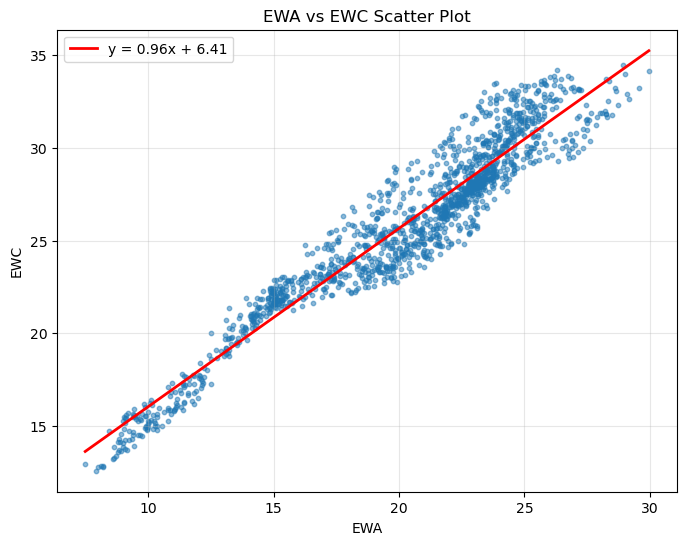

In [34]:
if df_ewa_ewc_ige is not None:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(df['EWA'], df['EWC'], alpha=0.5, s=10)
    ax.set_xlabel('EWA')
    ax.set_ylabel('EWC')
    ax.set_title('EWA vs EWC Scatter Plot')
    ax.grid(True, alpha=0.3)
    
    # 회귀선 추가
    x_line = np.linspace(df['EWA'].min(), df['EWA'].max(), 100)
    y_line = results_ols.params['Intercept'] + hedge_ratio * x_line
    ax.plot(x_line, y_line, 'r-', linewidth=2, label=f'y = {hedge_ratio:.2f}x + {intercept:.2f}')
    ax.legend()
    plt.show()

### 4.2 EWA vs EWC 산점도

> 📊 두 ETF 가격이 **직선 관계**에 가깝게 분포 → 공적분 가능성 시각적 확인

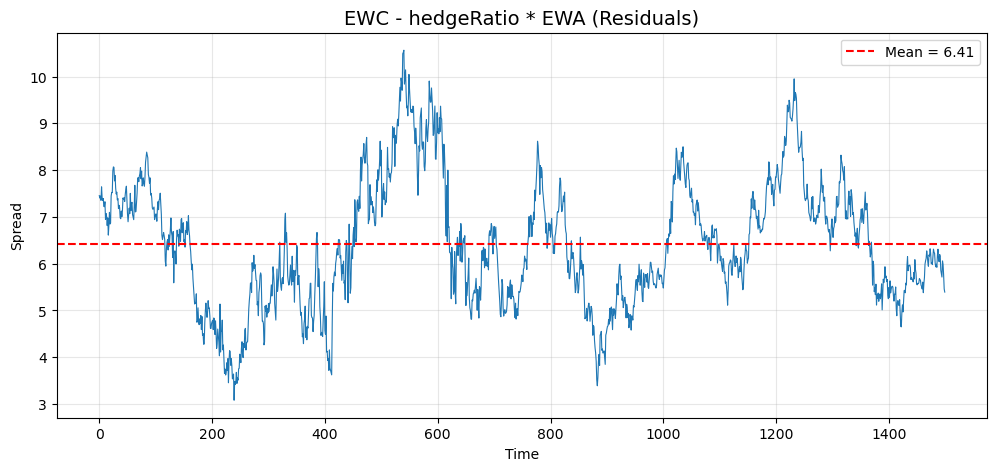

In [35]:
if df_ewa_ewc_ige is not None:
    residuals = df['EWC'] - hedge_ratio * df['EWA']
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.plot(residuals.values, linewidth=0.8)
    ax.axhline(y=residuals.mean(), color='r', linestyle='--', label=f'Mean = {residuals.mean():.2f}')
    ax.set_title('EWC - hedgeRatio * EWA (Residuals)', fontsize=14)
    ax.set_xlabel('Time')
    ax.set_ylabel('Spread')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()

### 4.3 스프레드 (잔차) 차트

> 📉 스프레드(EWC - β×EWA)가 **평균 주변에서 진동** → 평균 회귀 거래 가능성

### 4.4 EWA-EWC-IGE 포트폴리오 (Johansen Test)

**Johansen 검정의 장점**:
- 2개 이상의 자산에 대한 공적분 검정 가능
- 가격 시계열의 **순서에 독립적** (CADF와 달리)
- **고유벡터**를 헤지 비율로 사용 가능

**추가 자산: IGE (iShares North American Natural Resources ETF)**
- 천연자원 관련 주식으로 구성
- 호주/캐나다 경제와 밀접한 연관

In [36]:
if df_ewa_ewc_ige is not None:
    print("### 2.3 EWA-EWC-IGE 포트폴리오 Johansen 검정")
    
    result_j3 = vm.coint_johansen(df.values, det_order=0, k_ar_diff=1)
    
    print("  Trace 통계량:")
    for i, (stat, cv) in enumerate(zip(result_j3.lr1, result_j3.cvt)):
        reject = "✅" if stat > cv[1] else "❌"
        print(f"    r ≤ {i}: {stat:.4f} (임계값 95%: {cv[1]:.4f}) {reject}")
    
    print("\n  고유벡터 (헤지 비율):")
    for i, col in enumerate(df.columns):
        print(f"    {col}: {result_j3.evec[i, 0]:.4f}")

### 2.3 EWA-EWC-IGE 포트폴리오 Johansen 검정
  Trace 통계량:
    r ≤ 0: 34.4286 (임계값 95%: 29.7961) ✅
    r ≤ 1: 17.5317 (임계값 95%: 15.4943) ✅
    r ≤ 2: 4.4710 (임계값 95%: 3.8415) ✅

  고유벡터 (헤지 비율):
    EWA: 0.7600
    EWC: -1.0460
    IGE: 0.2233


**Trace 통계량 검정 (관계의 개수 찾기 '스무고개'):**

이 검정은 **"과연 이들 사이에 보이지 않는 끈(관계)이 몇 개($r$)나 있는가?"** 를 단계별로 확인하는 과정입니다.

| 단계 | 질문 (귀무가설) | 점수 (통계량) vs 커트라인 (임계값) | 판정 | 해석 |
|------|-------------------|---------------------------------------|------|------|
| **1단계** | "관계가 **0개** 이하인가?" ($r \le 0$) | **34.4** > 29.8 | ✅ **기각** (거짓말!) | "아니, 관계가 최소 1개는 있어." |
| **2단계** | "그럼 관계가 **1개** 이하인가?" ($r \le 1$) | **17.5** > 15.5 | ✅ **기각** (거짓말!) | "아니, 관계가 2개 이상이야." |
| **3단계** | "그럼 관계가 **2개** 이하인가?" ($r \le 2$) | **4.47** > 3.84 | ✅ **기각** (거짓말!) | "아니, 관계가 3개야." |

> 💡 **결론**: 기각(Reject)될 때마다 관계의 개수가 하나씩 늘어납니다. 3단계까지 모두 기각되었으므로, 이 세 자산은 **매우 강력하게 서로 얽혀 있다(3개의 공적분 관계)** 는 뜻입니다.

**최적 헤지 비율 (황금 배합 레시피):**

고유벡터는 세 자산을 섞어서 **"가장 안정적인(평균 회귀하는) 칵테일"** 을 만드는 **비율(레시피)** 입니다.

$$ \text{포트폴리오} = 0.76 \times \text{EWA} - 1.05 \times \text{EWC} + 0.22 \times \text{IGE} $$

| ETF | 가중치 | 포지션 | 비유 (레시피) |
|-----|--------|--------|---------------|
| **EWA** | 0.76 | Long (매수) | 호주 주식 **0.76잔 넣고** |
| **EWC** | -1.05 | Short (매도) | 캐나다 주식 **1.05잔 덜어내고** |
| **IGE** | 0.22 | Long (매수) | 천연자원 **0.22잔 넣음** |

> 💡 **직관적 이해**:
> - **EWC(캐나다)** 가 혼자 너무 튈 때, **EWA(호주)** 와 **IGE(천연자원)** 를 적절히 섞어주면 서로 움직임이 상쇄됩니다.
> - 이 비율대로 섞은 **'세트 메뉴(스프레드)'** 는 가격이 위아래로 흔들려도 금방 **평균(제자리)** 으로 돌아옵니다.
> - 가장 큰 고유값(Eigenvalue)에 해당하는 이 첫 번째 레시피가 **가장 빨리 평균으로 돌아오는(반감기가 짧은)** 최적의 조합입니다.

---

## 5. 반감기 분석 (Half-life)

### 📐 반감기의 의미

**반감기(Half-life)** 는 가격이 평균에서 벗어난 거리가 **절반으로 줄어드는 데 걸리는 시간**입니다.

$$t_{1/2} = -\frac{\log(2)}{\lambda}$$

**트레이딩 실용성:**
- 반감기가 **짧을수록** → 더 많은 왕복 거래 가능 → 높은 수익 기회
- 반감기를 **Lookback 기간**으로 사용하면 데이터 스누핑 없이 전략 설계 가능

In [37]:
if df_ewa_ewc_ige is not None:
    # 최적 고유벡터로 포트폴리오 가치 계산
    yport = pd.DataFrame(np.dot(df.values, result_j3.evec[:, 0]))
    
    # 반감기 계산을 위한 회귀
    ylag = yport.shift()
    deltaY = yport - ylag
    df_reg = pd.concat([ylag, deltaY], axis=1)
    df_reg.columns = ['ylag', 'deltaY']
    df_reg = df_reg.dropna()
    
    regress_results = smf.ols(formula="deltaY ~ ylag", data=df_reg).fit()
    lambda_coef = regress_results.params['ylag']
    halflife = -np.log(2) / lambda_coef
    
    print(f"  λ (회귀 계수): {lambda_coef:.6f}")
    print(f"  반감기: {halflife:.2f} 일")
    
    if halflife < 30:
        print(f"  → ✅ 단기 평균회귀: 트레이딩에 적합")
    elif halflife < 100:
        print(f"  → ⚠️ 중기 평균회귀: 스윙 트레이딩 가능")
    else:
        print(f"  → ❌ 장기 평균회귀: 실용성 낮음")

  λ (회귀 계수): -0.030586
  반감기: 22.66 일
  → ✅ 단기 평균회귀: 트레이딩에 적합


### 5.1 EWA-EWC-IGE 포트폴리오 반감기

| 파라미터 | 값 | 의미 |
|----------|------|------|
| λ (회귀 계수) | -0.030586 | 음수 = 평균 회귀 |
| **반감기** | **22.7일** | 평균으로 50% 회복 시간 |

> ✅ **평가**: 반감기 < 30일 → **단기 트레이딩에 적합**

> 💡 비교: USD/CAD의 반감기는 약 115일로 실용적이지 않음

---

## 6. 전략 백테스트

### 📈 선형 평균 회귀 전략

**전략 원리**: 포트폴리오 가격의 **Z-Score**에 비례하여 반대 포지션

```python
# Z-Score 계산
z_score = (portfolio_price - moving_avg) / moving_std

# 포지션 결정 (Z-Score의 음수에 비례)
num_units = -z_score
```

| Z-Score | 포지션 | 이유 |
|---------|--------|------|
| Z > 0 (평균 위) | Short | 가격 하락 예상 |
| Z < 0 (평균 아래) | Long | 가격 상승 예상 |
| Z ≈ 0 (평균 근처) | 중립 | 방향성 불확실 |

In [38]:
if df_ewa_ewc_ige is not None:
    # 반감기 기반 lookback 설정
    lookback = int(np.round(halflife))
    print(f"  Lookback 기간: {lookback} 일 (반감기 기반)")
    
    # Z-Score 기반 포지션
    ma = yport.rolling(lookback).mean()
    mstd = yport.rolling(lookback).std()
    numUnits = -(yport - ma) / mstd
    
    # 포지션 계산 (eigenvector 가중치 적용)
    positions = pd.DataFrame(
        np.dot(numUnits.values, np.expand_dims(result_j3.evec[:, 0], axis=1).T) * df.values
    )
    
    # P&L 계산
    pnl = np.sum(positions.shift().values * df.pct_change().values, axis=1)
    ret = pnl / np.sum(np.abs(positions.shift()), axis=1)
    ret = pd.Series(ret)
    
    # 성과 지표 계산
    ret_clean = ret.replace([np.inf, -np.inf], np.nan).dropna()
    
    total_return = (np.cumprod(1 + ret_clean) - 1).iloc[-1]
    apr = np.prod(1 + ret_clean) ** (252 / len(ret_clean)) - 1
    sharpe = np.sqrt(252) * np.mean(ret_clean) / np.std(ret_clean)
    
    # 최대 낙폭 계산
    cumret = np.cumprod(1 + ret_clean)
    highwatermark = cumret.cummax()
    drawdown = (cumret - highwatermark) / highwatermark
    max_dd = drawdown.min()
    
    print(f"  총 수익률: {total_return * 100:.2f}%")
    print(f"  연간 수익률 (APR): {apr * 100:.2f}%")
    print(f"  샤프 비율: {sharpe:.4f}")
    print(f"  최대 낙폭 (MDD): {max_dd * 100:.2f}%")

  Lookback 기간: 23 일 (반감기 기반)
  총 수익률: 102.38%
  연간 수익률 (APR): 12.78%
  샤프 비율: 1.4027
  최대 낙폭 (MDD): -10.12%


### 6.1 EWA-EWC-IGE 백테스트 결과

**전략 파라미터:**

- **Lookback 기간**: 23일 (반감기 기반 자동 설정)
- **거래 비용**: 미포함 (실제 적용 시 조정 필요)

**성과 지표:**

| 지표 | 값 | 평가 |
|------|------|------|
| 총 수익률 | 102.38% | 테스트 기간 전체 |
| 연간 수익률 (APR) | 12.78% | ✅ 우수 |
| **샤프 비율** | **1.4027** | ✅ 우수 |
| 최대 낙폭 (MDD) | -10.12% | ✅ 양호 |
| 거래일 수 | 1477일 | 테스트 기간 |

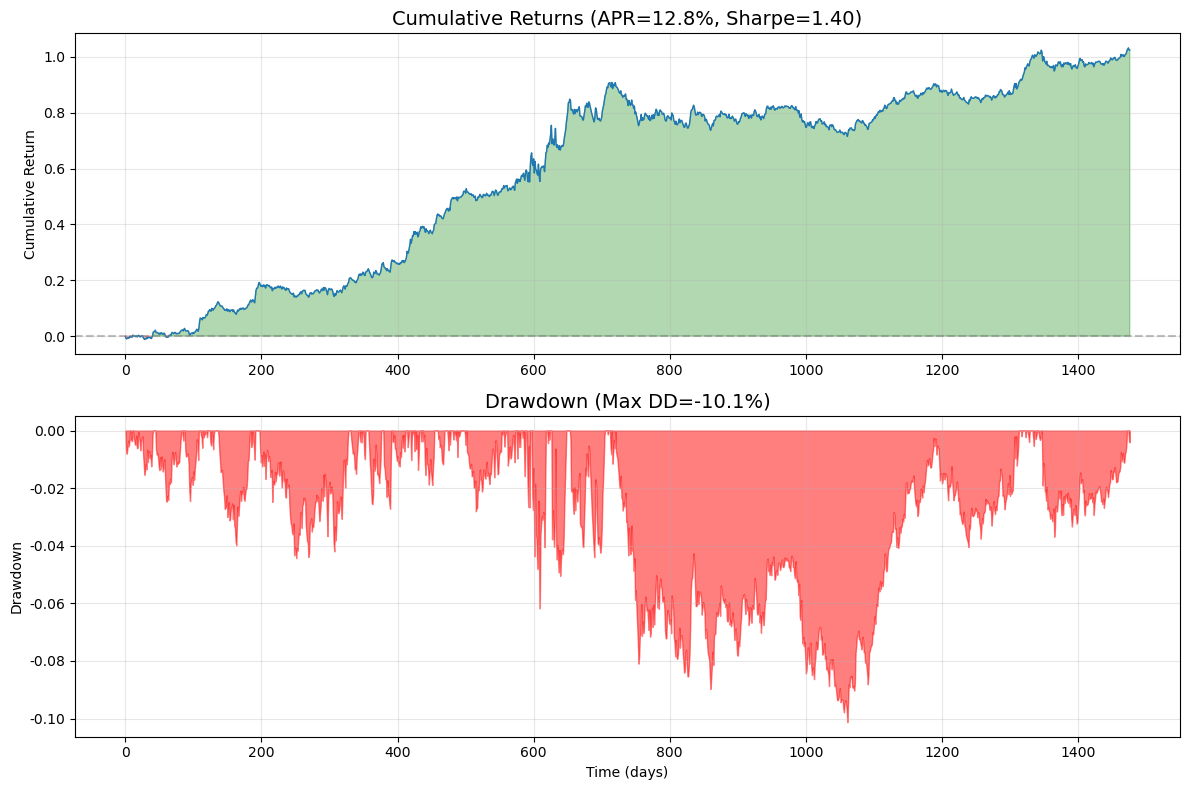

In [39]:
if df_ewa_ewc_ige is not None:
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))
    
    # 누적 수익률
    cumret_plot = np.cumprod(1 + ret_clean) - 1
    axes[0].plot(cumret_plot.values, linewidth=1)
    axes[0].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    axes[0].set_title(f'Cumulative Returns (APR={apr*100:.1f}%, Sharpe={sharpe:.2f})', fontsize=14)
    axes[0].set_ylabel('Cumulative Return')
    axes[0].grid(True, alpha=0.3)
    axes[0].fill_between(range(len(cumret_plot)), 0, cumret_plot.values, 
                       where=cumret_plot.values >= 0, alpha=0.3, color='green')
    axes[0].fill_between(range(len(cumret_plot)), 0, cumret_plot.values, 
                       where=cumret_plot.values < 0, alpha=0.3, color='red')
    
    # 드로다운
    axes[1].fill_between(range(len(drawdown)), 0, drawdown.values, alpha=0.5, color='red')
    axes[1].set_title(f'Drawdown (Max DD={max_dd*100:.1f}%)', fontsize=14)
    axes[1].set_xlabel('Time (days)')
    axes[1].set_ylabel('Drawdown')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### 6.2 누적 수익률 및 낙폭 차트

> 📊 **차트 해석**:
> - 상단: 누적 수익률 (녹색=수익, 빨간색=손실)
> - 하단: 드로다운 (최고점 대비 하락폭)

---

## 7. 결론 및 권고사항

### ✅ 핵심 발견

| 분석 대상 | 결과 | 트레이딩 가능성 |
|-----------|------|----------------|
| USD/CAD | ADF 통과 실패, H=0.48 | ⚠️ 단독 거래 어려움 |
| EWA-EWC | 공적분 p=0.10 | ✅ 페어 트레이딩 |
| EWA-EWC-IGE | 반감기=23일 | ✅ 단기 트레이딩 적합 |
| 선형 전략 | 샤프=1.40 | ✅ 양호한 위험조정수익 |

### 💡 트레이딩 권고사항

1. **포트폴리오 구성**:
   - EWA-EWC-IGE 3자산 포트폴리오에 평균회귀 전략 적용
   - Johansen 고유벡터 기반 헤지 비율 사용

2. **전략 고도화** (Chapter 3 참조):
   - 볼린저 밴드: 진입/청산 임계값 최적화
   - 칼만 필터: 시변(time-varying) 헤지 비율 적용

3. **리스크 관리** (Chapter 8 참조):
   - 평균회귀 전략은 **꼬리 리스크(Tail Risk)** 존재
   - 켈리 공식 기반 레버리지 관리 필수
   - 일반적인 손절매는 논리적이지 않음 (더 벌어질수록 더 매력적)

### ⚠️ 주의사항

- 본 백테스트는 **거래 비용 미포함**
- **Look-ahead bias**: 전체 데이터로 반감기 계산 후 동일 데이터로 테스트
- 실제 적용 시 **Walk-forward 테스트** 필요
- 시장 구조 변화(Regime Shift)에 취약할 수 있음

---

*이 리포트는 `run_chapter2_analysis.py`에 의해 자동 생성되었습니다.*